# Building a biorefinery

Putting it all together, we can finally build a complete biorefinery from scratch. The following examples should help guide this process.

## Sugarcane biorefinery

In this example, a sugarcane biorefinery for the production of ethanol is designed according to [[1]](#References), including all process setings, prices, and assumptions. Some heat integration is not included here for simplicity.

### Thermodynamic property package

First create the thermodynamic property package to define the chemicals in the process. We can follow the [example](https://thermosteam.readthedocs.io/en/latest/tutorial/Thermo%20property%20packages.html) in Thermosteam's docs to do this:

In [1]:
import biosteam as bst

chemicals = bst.Chemicals(
    ['Water', # Define common chemicals by name
     'Ethanol',
     'Octane',
     bst.Chemical('Glucose', phase='s'), # Set the phase for chemicals not in vapor-liquid equilibrium
     bst.Chemical('Sucrose', phase='s'),
     bst.Chemical('H3PO4', phase='s'),
     bst.Chemical('P4O10',
                  rho=1540, # Density [kg/m3]
                  default=True,  # Default other chemicals properties like viscosity to that of water at 25 C  
                  phase='s'),
     bst.Chemical('CO2', phase='g'),
     bst.Chemical('O2', phase='g'),
     bst.Chemical('Cellulose',
                  Cp=1.364, # Heat capacity [kJ/kg]
                  rho=1540, # Density [kg/m3]
                  default=True, # Default other chemicals properties like viscosity to that of water at 25 C 
                  search_db=False, # Not in database, so do not search the database
                  phase='s',
                  formula="C6H10O5", # Glucose monomer minus water, molecular weight is computed based on formula
                  Hf=-975708.8), # Heat of formation [J/mol]
     bst.Chemical('Hemicellulose',
                  Cp=1.364,
                  rho=1540,
                  default=True,
                  search_db=False,
                  phase='s',
                  formula="C5H8O5", # Xylose monomer minus water
                  Hf=-761906.4),
     bst.Chemical('Lignin',
                  Cp=1.364,
                  rho=1540,
                  default=True,
                  search_db=False,
                  phase='s',
                  formula='C8H8O3', # Vainillin formula
                  Hf=-452909.632),
     bst.Chemical('Flocculant',
                  Cp=4.184,
                  rho=1540,
                  default=True,
                  search_db=False,
                  phase='s',
                  MW=1.), # No formula, so molecular weight should be defined
     bst.Chemical('Solids',
                  Cp=1.100,
                  rho=1540,
                  default=True,
                  search_db=False,
                  phase='s',
                  MW=1.),
     bst.Chemical('DryYeast',
                  rho=1540,
                  default=True,
                  search_db=False,
                  phase='s',
                  MW=1.,
                  synonyms={'Yeast'}),
     bst.Chemical('CaO',
                  Cp=1.02388,
                  rho=1540,
                  default=True,
                  search_db=False,
                  phase='s',
                  formula='CaO'),
     bst.Chemical('Ash', 
                  rho=1540,
                  Cp=0.37656,
                  default=True,
                  search_db=False,
                  phase='s',
                  MW=1.)]
)
bst.settings.set_thermo(chemicals)

### Process settings

Before any simulations, we define the conditions of all our utilities and the Chemical Engineering Plant Cost Indes (CEPCI):

In [2]:
bst.CE = 567 # CEPCI: 2013
bst.PowerUtility.price = 0.065
HeatUtility = bst.HeatUtility
# Steam is produced on-site by a boiler,
# so make it the only available heating agent.
steam_utility = HeatUtility.get_agent('low_pressure_steam')
HeatUtility.heating_agents = [steam_utility]
steam_utility.heat_transfer_efficiency = 0.85
steam_utility.T = 529.2
steam_utility.P = 44e5

# Steam, cooling water, and chilled water are regenerated by
# on-site facilities. The regeneration and heat transfer
# prices are given accounted for by the capital cost and
# electricity consumption of these facilities
steam_utility.regeneration_price = 0.
HeatUtility.get_agent('cooling_water').regeneration_price = 0
HeatUtility.get_agent('chilled_water').heat_transfer_price = 0

# Raw material price (USD/kg)
price = {'Sugar cane': 0.03455, # 70% m.c
         'Water': 0.000353,
         'HCl': 0.205,
         'Lime': 0.077,
         'H3PO4': 0, # Not significant
         'NaOH':0.41,
         'Protease': 0.5,
         'Polymer': 0, # Not significant
         'Steam': 0.017,
         'Ethanol': 0.789,
         'Waste': -0.33,
         'Gasoline': 0.756} # 2 USD/gal

### Unit operations and simulation

First define the unit operations for feedstock handling and juicing:

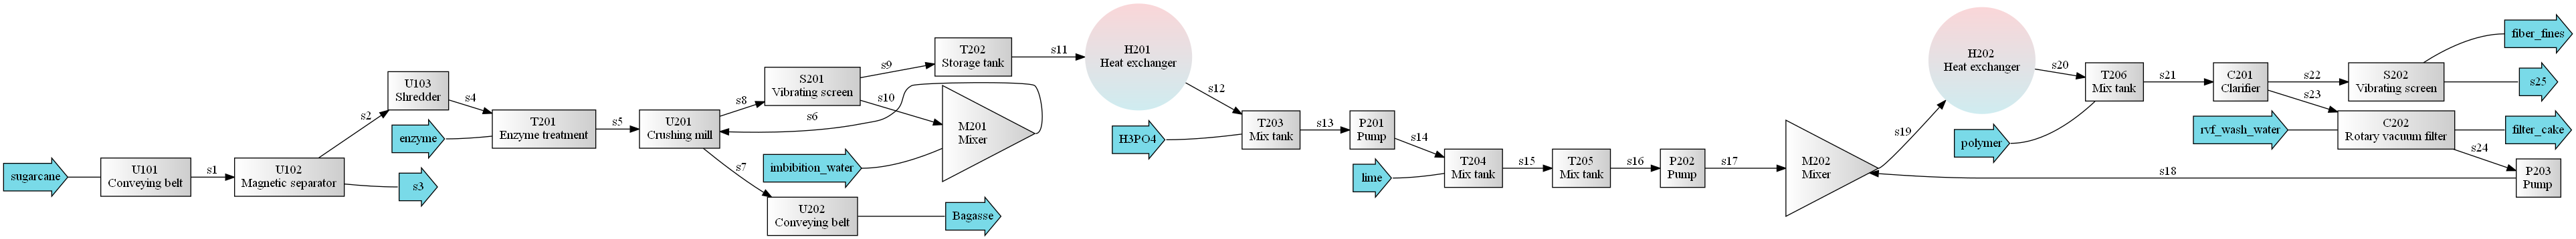

In [3]:
from biosteam import units
import numpy as np

bst.main_flowsheet.set_flowsheet('sugarcane_ethanol')
chemicals.define_group( # We can create streams and set component splits faster by defining chemical groups
    name='Fiber',
    IDs=['Cellulose', 'Hemicellulose', 'Lignin'],
    composition=[0.4704 , 0.2775, 0.2520],
    wt=True, # Composition is given as weight
)
chemicals.define_group(
    name='Sugar',
    IDs=['Sucrose', 'Glucose'],
    # Default composition as equimolar
)

sugarcane = bst.Stream(
    'sugarcane',
    Water=0.7,
    Glucose=0.01208,
    Sucrose=0.1369,
    Ash=0.006,
    Fiber=0.13,
    Solids=0.015,
    total_flow=333334.2,
    units='kg/hr',
    price=price['Sugar cane']
)

enzyme = bst.Stream('enzyme',
                    Cellulose=100, Water=900, units='kg/hr',
                    price=price['Protease'])

imbibition_water = bst.Stream('imbibition_water',
                              Water=87023.35, units='kg/hr',
                              T = 338.15)

H3PO4 = bst.Stream('H3PO4',
                   H3PO4=74.23, Water=13.10, units='kg/hr',
                   price=price['H3PO4'])  # to T203

lime = bst.Stream('lime',
                  CaO=333.00, Water=2200.00, units='kg/hr',
                  price=price['Lime'])  # to P5

polymer = bst.Stream('polymer',
                     Flocculant=0.83, units='kg/hr',
                     price=price['Polymer'])  # to T205

rvf_wash_water = bst.Stream('rvf_wash_water',
                            Water=16770, units='kg/hr',
                            T=363.15)  # to C202

### Unit operations ###

# Feed the shredder
U101 = units.ConveyingBelt('U101', sugarcane)

# Separate metals
U102 = units.MagneticSeparator('U102', U101-0)

# Shredded cane
U103 = units.Shredder('U103', U102-0)

# Hydrolyze starch
T201 = units.EnzymeTreatment('T201', [U103-0, enzyme], T=323.15)  # T=50

# Finely crush lipid cane
imbibition_water_recycle = bst.Stream() # To connect later
U201 = units.CrushingMill('U201', [T201-0, imbibition_water_recycle],
                          split=dict(Ash=0.92,
                                     Fiber=0.92,
                                     Sugar=0.04,
                                     Solids=1),
                          moisture_content=0.5)

# Convey out bagasse
U202 = units.ConveyingBelt('U202', U201-0, outs='Bagasse')

# Screen out fibers
S201 = units.VibratingScreen('S201', U201-1,
                             split=dict(Ash=0.35,
                                        Fiber=0.35,
                                        Sugar=0.88,
                                        Water=0.88,
                                        Solids=0))

# Mix in water
M201 = units.Mixer('M201', [S201-1, imbibition_water], imbibition_water_recycle)

# Store juice before treatment
T202 = units.StorageTank('T202', S201-0, tau=4, vessel_material='Carbon steel')

# Heat up before adding acid
H201 = units.HXutility('H201', T202-0, T=343.15)

# Mix in acid
T203 = units.MixTank('T203', [H201-0, H3PO4])

# Pump acid solution
P201 = units.Pump('P201', T203-0)

# Mix lime solution
T204 = units.MixTank('T204', [P201-0, lime], tau=0.10)

# Blend acid lipid solution with lime
T205 = units.MixTank('T205', T204-0, tau=0.10)
P202 = units.Pump('P202', T205-0)

# Mix recycle
RVF_recycle = bst.Stream() # From rotary vacuum filter; connect later
M202 = units.Mixer('M202', [P202-0, RVF_recycle])

# Heat before adding flocculant
H202 = units.HXutility('H202', M202-0, T=372.15)

# Mix in flocculant
T206 = units.MixTank('T206', [H202-0, polymer])
T206.tau = 0.10

# Separate residual solids
C201 = units.Clarifier('C201', T206-0,
                       split=dict(Ash=0,
                                  CaO=0,
                                  Fiber=0,
                                  Flocculant=0.522,
                                  Sugar=0.522,
                                  H3PO4=0.522,
                                  Water=0.522))

# Remove solids as filter cake
C202 = units.RVF('C202', [C201-1, rvf_wash_water],
                 outs=('filter_cake', ''),
                 moisture_content=0.80,
                 split=dict(Ash=0.85,
                            CaO=0.85,
                            Fiber=0.85,
                            Sugar=0.01))
P203 = units.Pump('P203', C202-1, RVF_recycle)


# Screen out small fibers from sugar stream
S202 = units.VibratingScreen('S202', C201-0,
                             outs=('', 'fiber_fines'),
                             split=dict(Ash=1.0,
                                        CaO=1.0,
                                        Fiber=1.0,
                                        Flocculant=0.0,
                                        Sugar=0.998,
                                        H3PO4=1.0,
                                        Water=0.998))
S202.mesh_opening = 2

### Process specifications ###

# Specifications dependent on lipid cane flow rate
@U103.add_specification(run=True) # Run unit operation afterwords
def correct_flows():
    feedstock = U101.ins[0]
    F_mass = feedstock.F_mass
    # correct enzyme, lime, phosphoric acid, and imbibition water
    enzyme.imass['Cellulose', 'Water'] = 0.003 * F_mass * np.array([0.1, 0.9])
    lime.imass['CaO', 'Water'] = 0.001 * F_mass * np.array([0.046, 0.954])
    H3PO4.imass['H3PO4', 'Water'] = 0.00025 * F_mass
    imbibition_water.imass['Water'] = 0.25* F_mass

# Specifications within a system
@P202.add_specification(run=True)
def correct_wash_water():
    solids = P202.ins[0].imol['Ash', 'CaO', 'Fiber'].sum()
    rvf_wash_water.imol['Water'] = 0.0574 * solids

bst.main_flowsheet.diagram() # Flow sheet up until now

Define unit operations for ethanol production from juice:

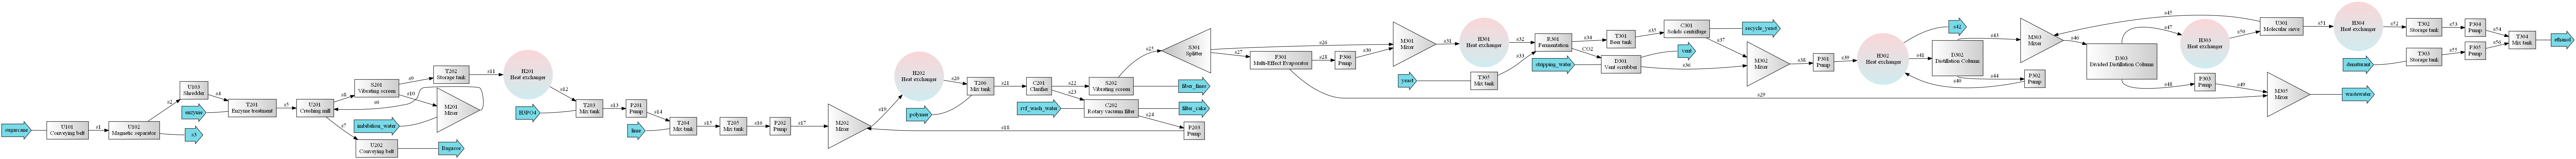

In [4]:
import flexsolve as flx # Package with numerical solvers similar to scipy

### Streams ###
    
# Fresh water
stripping_water = bst.Stream('stripping_water', Water=5000, units='kg/hr')

# Gasoline
denaturant = bst.Stream('denaturant', Octane=230.69,
                        units='kg/hr', price=price['Gasoline'])

sugar_solution = S202-0

# Yeast
yeast = bst.Stream('yeast', Water=24700, DryYeast=10300, units='kg/hr')

# Ethanol product
ethanol = bst.Stream('ethanol', price=price['Ethanol'])

### Units ###

# Split sugar solution
S301 = units.Splitter('S301', sugar_solution, split=0.10)

# Concentrate sugars
F301 = units.MultiEffectEvaporator('F301', S301-1,
                                   P=(101325, 73581, 50892, 32777),
                                   V_definition='First-effect',
                                   V=0.1) # fraction evaporated
P306 = units.Pump('P306', F301-0)

# Mix sugar solutions
M301 = units.Mixer('M301', [P306-0, S301-0])

def get_sugar_concentration():
    s = M301.outs[0]
    if 'Lipid' in s.chemicals:
        ignored = float(s.imass['Lipid'])
    else:
        ignored = 0.
    return s.imass['Glucose', 'Sucrose'].sum() / (s.F_mass - ignored)
    
def sugar_concentration_at_fraction_evaporated(V):
    F301.V = V
    for i in F301.path_until(M301): i._run()
    M301._run()
    return F301.sugar_concentration - get_sugar_concentration()

@F301.add_specification
def adjust_sugar_concentration():
    # Solve for vapor fraction that gets the required sugar concentration
    F301.V = flx.IQ_interpolation(
        f=sugar_concentration_at_fraction_evaporated,
        x0=0., 
        x1=1., 
        ytol=0.01
    )
    
F301.sugar_concentration = 0.23 # wt. % sugar

# Cool for fermentation
H301 = units.HXutility('H301', M301-0, T=295.15)

# Yeast preparation
T305 = units.MixTank('T305', yeast)
T305.tau = 0.1

# Ethanol Production
R301 = units.Fermentation('R301', [H301-0, T305-0], outs=('CO2', ''), tau=9, efficiency=0.90, N=4) 
R301.cell_growth_reaction.X = 0. # Ignore for simplicity
T301 = units.StorageTank('T301', R301-1, tau=4, vessel_material='Carbon steel')
T301.line = 'Beer tank' # Changes name on the diagram

D301 = units.VentScrubber('D301', ins=(stripping_water, R301-0), 
                          outs=('vent', ''),
                          gas=('CO2',))

# Separate 99% of yeast
C301 = units.SolidsCentrifuge('C301', T301-0, outs=('', 'recycle_yeast'),
                            split=(1, 0.99999, 1, 0.01),
                            order=('Ethanol', 'Glucose', 'H3PO4', 'DryYeast'),
                            solids=('DryYeast',))

# Add bottoms from scrubber
M302 = units.Mixer('M302', [C301-0, D301-1])
P301 = units.Pump('P301', M302-0)

# Heat up before beer column
# Exchange heat with stillage
bottoms_product = bst.Stream() # Bottoms product from beer column, connect later
H302 = units.HXprocess('H302', [P301-0, bottoms_product], U=1.28)

# Beer column
D302 = units.BinaryDistillation('D302', H302-0, P=101325,
                                Lr=0.99999, Hr=0.60, # Light and heavy key recoveries
                                LHK=('Ethanol', 'Water'), # Light and heavy key
                                k=1.25) # Actual reflux over minimum reflux ratio
D302.tray_material = 'Stainless steel 304'
D302.vessel_material = 'Stainless steel 304'
D302.boiler.U = 1.85
P302 = units.Pump('P302', D302-1, bottoms_product)

# Mix ethanol Recycle (Set-up)
molecular_sieve_recycle = bst.Stream()
M303 = units.Mixer('M303', [D302-0, molecular_sieve_recycle])

D303 = units.BinaryDistillation('D303', M303-0, P=101325,
                            y_top=0.80805, x_bot=3.91e-06,  # Molar fraction of light key in the distillate and bottoms product
                            k=1.25,
                            LHK=('Ethanol', 'Water'),
                            tray_material='Stainless steel 304',
                            vessel_material='Stainless steel 304',
                            is_divided=True)
D303.boiler.U = 1.85
P303 = units.Pump('P303', D303-1)

# Superheat vapor for mol sieve
H303 = units.HXutility('H303', D303-0, T=115+273.15, V=1, heat_only=True)

# Molecular sieve
U301 = units.MolecularSieve('U301', H303-0, [molecular_sieve_recycle, ''],
                            split=dict(Ethanol=0.1621,
                                       Water=0.925))

# Condense ethanol product
H304 = units.HXutility('H304', U301-1, V=0, T=340.)
T302 = units.StorageTank('T302', H304-0, tau=7*24, # 1 week storage capacity
                         vessel_type='Floating roof',
                         vessel_material='Carbon steel')
P304 = units.Pump('P304', T302-0)

# Storage for denaturant
T303 = units.StorageTank('T303', denaturant, tau=7*24,
                         vessel_type='Floating roof',
                         vessel_material='Carbon steel')
P305 = units.Pump('P305', T303-0)

# Denatured ethanol product
T304 = units.MixTank('T304', [P305-0, P304-0], outs=ethanol)
T304.tau = 0.10 # 6 min residence time

# Waste water
M305 = units.Mixer('M305', [P303-0, F301-1], outs='wastewater')

@P304.add_specification(run=True)
def adjust_denaturant():
    pure_ethanol = P304.ins[0]
    denaturant.imol['Octane'] = 0.021*pure_ethanol.F_mass/114.232

bst.main_flowsheet.diagram('thorough') # Flow sheet up until now

Define facilities which use data from unit operations to solve for utility requirements:

In [5]:
s = bst.main_flowsheet.stream
BT = units.BoilerTurbogenerator('BT',
                                (U202-0, '', 'boiler_makeup_water', 'natural_gas', '', ''),
                                boiler_efficiency=0.80,
                                turbogenerator_efficiency=0.85)

CT = units.CoolingTower('CT')
makeup_water = bst.Stream('makeup_water', price=0.000254)

CWP = units.ChilledWaterPackage('CWP')
PWC = units.ProcessWaterCenter('PWC',
                               ins=(bst.Stream(), makeup_water),
                               outs=(),
                               makeup_water_streams=(s.cooling_tower_makeup_water,
                                                     s.boiler_makeup_water),
                               process_water_streams=(imbibition_water,
                                                      rvf_wash_water,
                                                      stripping_water,
                                                      s.cooling_tower_makeup_water,
                                                      s.boiler_makeup_water))

Create the system and simulate:

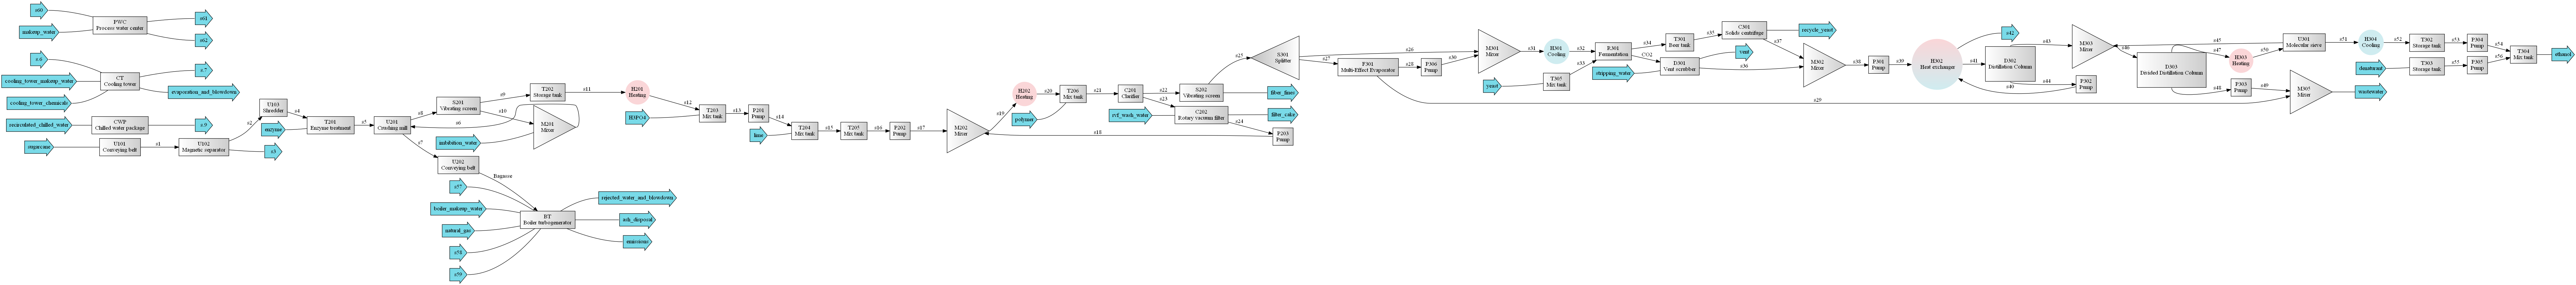

In [6]:
sugarcane_sys = bst.main_flowsheet.create_system('sugarcane_sys')
sugarcane_sys.simulate()
sugarcane_sys.diagram('thorough', format='png')

BioSTEAM generates nested systems to solve recycle streams more robustly. It may be fun to view these systems as follows:

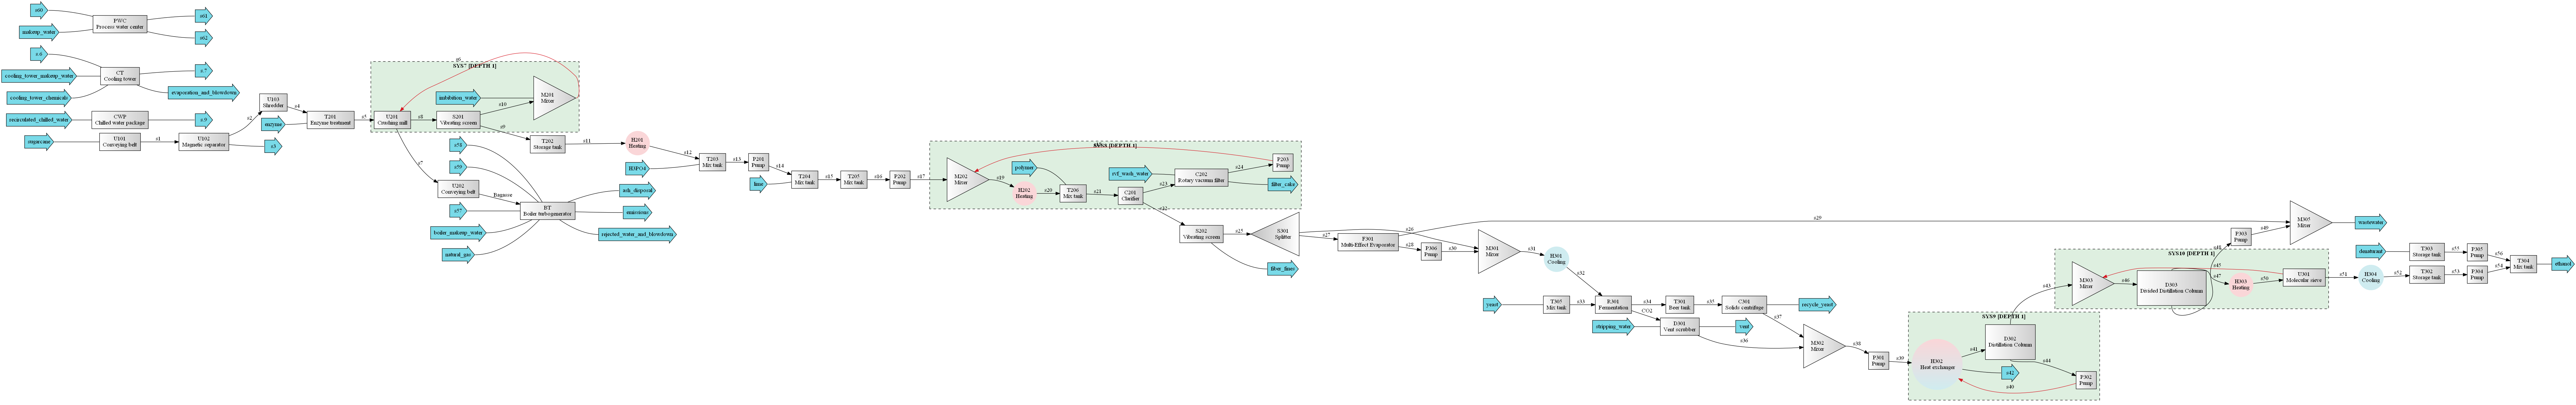

In [7]:
sugarcane_sys.diagram('cluster', format='png') # Red streams are recycles (i.e. tear streams)

In [8]:
sugarcane_sys.print()

System('sugarcane_sys',
    [U101,
     U102,
     U103,
     T201,
     System('SYS7',
        [U201,
         S201,
         M201],
        recycle=M201-0),
     T202,
     H201,
     T203,
     P201,
     T204,
     T205,
     P202,
     System('SYS8',
        [M202,
         H202,
         T206,
         C201,
         C202,
         P203],
        recycle=P203-0),
     S202,
     S301,
     F301,
     P306,
     M301,
     H301,
     T305,
     R301,
     T301,
     C301,
     D301,
     M302,
     P301,
     System('SYS9',
        [H302,
         D302,
         P302],
        recycle=P302-0),
     System('SYS10',
        [M303,
         D303,
         H303,
         U301],
        recycle=U301-0),
     H304,
     T302,
     P304,
     T303,
     P305,
     T304,
     P303,
     M305,
     U202],
    facilities=[BT,
     CWP,
     CT,
     PWC])


### Techno-economic analysis

Subclass from BioSTEAM's TEA class to perform techno-economic analysis:

In [9]:
class SugarcaneTEA(bst.TEA):
    """
    Create a SugarcaneTEA object for techno-economic analysis of a biorefinery [1]_.
    
    Parameters
    ----------    
    system : System
        Should contain feed and product streams.
    IRR : float
        Internal rate of return (fraction).
    duration : tuple[int, int]
        Start and end year of venture (e.g. (2018, 2038)).
    depreciation : str
        'MACRS' + number of years (e.g. 'MACRS7').
    operating_days : float
        Number of operating days per year.
    income_tax : float
        Combined federal and state income tax rate (fraction).
    lang_factor : float
        Lang factor for getting fixed capital investment from
        total purchase cost. If no lang factor, estimate capital investment
        using bare module factors.
    startup_schedule : tuple[float]
        Startup investment fractions per year 
        (e.g. (0.5, 0.5) for 50% capital investment in the first year and 50%
        investment in the second).
    WC_over_FCI : float
        Working capital as a fraction of fixed capital investment.
    labor_cost : float
        Total labor cost (USD/yr).
    fringe_benefits : float
        Cost of fringe benefits as a fraction of labor cost.
    property_tax : float
        Fee as a fraction of fixed capital investment.
    property_insurance : float
        Fee as a fraction of fixed capital investment.    
    supplies : float
        Yearly fee as a fraction of labor cost.
    maintenance : float
        Yearly fee as a fraction of fixed capital investment.
    administration : float
        Yearly fee as a fraction of fixed capital investment.

    References
    ----------
    .. [1] Huang, H., Long, S., & Singh, V. (2016). Techno-economic analysis of biodiesel
        and ethanol co-production from lipid-producing sugarcane. Biofuels, Bioproducts
        and Biorefining, 10(3), 299–315. https://doi.org/10.1002/bbb.1640
    
    """
    
    __slots__ = ('labor_cost', 'fringe_benefits', 'maintenance',
                 'property_tax', 'property_insurance', '_FCI_cached',
                 'supplies', 'maintanance', 'administration')
    
    def __init__(self, system, IRR, duration, depreciation, income_tax,
                 operating_days, lang_factor, construction_schedule, WC_over_FCI,
                 labor_cost, fringe_benefits, property_tax,
                 property_insurance, supplies, maintenance, administration):
        super().__init__(system, IRR, duration, depreciation, income_tax,
                         operating_days, lang_factor, construction_schedule,
                         startup_months=0, startup_FOCfrac=0, startup_VOCfrac=0,
                         startup_salesfrac=0, finance_interest=0, finance_years=0, 
                         finance_fraction=0, WC_over_FCI=WC_over_FCI)
        self.labor_cost = labor_cost
        self.fringe_benefits = fringe_benefits
        self.property_tax = property_tax
        self.property_insurance = property_insurance
        self.supplies= supplies
        self.maintenance = maintenance
        self.administration = administration
        
    def _DPI(self, installed_equipment_cost):
        return installed_equipment_cost
        
    def _TDC(self, DPI):
        return DPI
    
    def _FCI(self, TDC):
        self._FCI_cached = TDC
        return TDC
    
    def _FOC(self, FCI):
        return (FCI*(self.property_tax + self.property_insurance
                     + self.maintenance + self.administration)
                + self.labor_cost*(1+self.fringe_benefits+self.supplies))

sugarcane_tea = SugarcaneTEA(system=sugarcane_sys,
                             IRR=0.15,
                             duration=(2018, 2038),
                             depreciation='MACRS7',
                             income_tax=0.35,
                             operating_days=200,
                             lang_factor=3,
                             construction_schedule=(0.4, 0.6),
                             WC_over_FCI=0.05,
                             labor_cost=2.5e6,
                             fringe_benefits=0.4,
                             property_tax=0.001,
                             property_insurance=0.005,
                             supplies=0.20,
                             maintenance=0.01,
                             administration=0.005)

sugarcane_tea.IRR = sugarcane_tea.solve_IRR()
sugarcane_tea.show()

SugarcaneTEA: sugarcane_sys
 NPV: 0 USD at 9.9% IRR


Generate a breakdown of results by biorefinery area with BioSTEAM's UnitGroup objects:

In [10]:
UnitGroup = bst.process_tools.UnitGroup
juicing = UnitGroup('Juicing', 
                    [U101, U102, U103, T201,
                     U201, S201, M201, T202,
                     H201, T203, P201, T204,
                     T205, P202, M202, H202,
                     T206, C201, C202, P203,
                     S202])
ethanol_production = UnitGroup('Ethanol production',
                               [S301, F301, P306, M301,
                                H301, T305, R301, T301,
                                C301, M302, P301, H302,
                                D302, P302, M303, D303,
                                H303, U301, H304, T302,
                                P304, T303, P305, T304,
                                D301, P303, M305])
facilities = UnitGroup('Facilities', sugarcane_sys.facilities)
groups = [juicing, ethanol_production, facilities]
UnitGroup.df_from_groups(groups)


,Installed equipment cost [MM$],Cooling duty [GJ/hr],Heating duty [GJ/hr],Electricity consumption [MW],Materiral cost [USD/hr]
Juicing,20.2,0,113,5.16,1.2e+04
Ethanol production,16.7,201,183,0.545,362
Facilities,69.2,83.1,0,4.53,35.7


In [11]:
# It is also possible to automatically group units by area
area_groups = UnitGroup.group_by_area(sugarcane_sys.units)

# Use short names for metrics
for group in area_groups: group.autofill_metrics(shorthand=True)

area_names = {'0': 'Facilities',
              '100': 'Feedstock handling',
              '200': 'Juicing',
              '300': 'Ethanol production'}
for i in area_groups: i.name = area_names[i.name]
UnitGroup.df_from_groups(area_groups)

,Inst. eq. cost [MM$],Cooling [GJ/hr],Heating [GJ/hr],Elec. cons. [MW],Mat. cost [USD/hr]
Facilities,69.2,83.1,0,4.53,35.7
Feedstock handling,5.04,0,0,2.01,1.15e+04
Juicing,15.2,0,113,3.15,526
Ethanol production,16.7,201,183,0.545,362


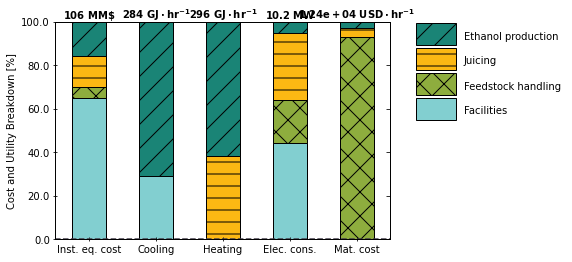

In [12]:
# For convinience, BioSTEAM has plotting methods centered on UnitGroup objects
bst.plots.plot_unit_groups(area_groups, fraction=True)

## Agile sugarcane and sweet sorghum biorefinery

### Agile systems overview

BioSTEAM is able to conservatively design agile biorefineries that can switch configurations, vary feedstocks, and even vary operating conditions throughout the year. Switching **operation modes** throughout the year is modeled using an **AgileSystem** object, which simulates each mode of operation and compiles new **agile designs** for each unit operation suitable for all operation modes. For example, an agile distillation column would have the largest diameter and number of operating stages required among all operation modes. Each operation mode runs for a defined number of operating hours, allowing the variable operating costs (e.g. material and utility costs) and sales to be summed across different operation modes. This **preliminary** agile design assumption leads to **conservative** estimates around utility costs as some units may be **over-designed**. For example, a distillation column with a higher number of stages will require a lower reflux ratio and less utilities to reach a target separation. The following UML diagram summarizes how BioSTEAM agile biorefinery models work:

![Agile System UML](Agile_System_UML.png "Agile System UML")

### Creating an agile sytem

An AgileSystem object is first created, then operation modes are added. We will need two operation modes, one for sugarcane and one for sorghum. As an example, we expose fermentation efficiency as an operation parameter. Finally, we add operation modes for both sugarcane and sorghum processing and simulate:

In [13]:
# Create new soghum system; which is exactly the same as sugarcane but with a different feedstock
U101.ins[0] = None # Remove stream without warnings
U101.ins[0] = sorghum = bst.Stream(
    'Sorghum',
    Water=0.7,
    Glucose=0.0111,
    Sucrose=0.126,
    Ash=0.006,
    Cellulose=0.0668,
    Hemicellulose=0.0394,
    Lignin=0.0358,
    Solids=0.015,
    total_flow=333334,
    units='kg/hr',
)
sorghum_sys = bst.System.from_units('sorghum_sys', sugarcane_sys.units)

# Create the agile system object and define operation parameters
agile_sys = bst.AgileSystem()

@agile_sys.operation_parameter
def set_fermentation_efficiency(X):
    R301.X = X
    
# The name of the parameter defaults to the name used in the function (X)
sugarcane_mode = agile_sys.operation_mode(system=sugarcane_sys, operating_hours=24*200, X=0.90)

# Assume fermentation of sorghum is less efficient for demonstration purposes
sorghum_mode = agile_sys.operation_mode(system=sorghum_sys, operating_hours=24*60, X=0.85) 

# Recreate the TEA object using the agile system
agile_tea = SugarcaneTEA(
    system=agile_sys,
    IRR=0.15,
    duration=(2018, 2038),
    depreciation='MACRS7',
    income_tax=0.35,
    operating_days=200,
    lang_factor=3,
    construction_schedule=(0.4, 0.6),
    WC_over_FCI=0.05,
    labor_cost=2.5e6,
    fringe_benefits=0.4,
    property_tax=0.001,
    property_insurance=0.005,
    supplies=0.20,
    maintenance=0.01,
    administration=0.005,
)

# Simulate and get results
agile_sys.simulate()
agile_tea.IRR = agile_tea.solve_IRR()
print('Agile Sugarcane/Sorghum')
print(f'NPV: {agile_tea.NPV/1e6:.2f}')
print(f'IRR: {agile_tea.IRR:.0%}')

Agile Sugarcane/Sorghum
NPV: -0.00
IRR: 15%


While the IRR is higher due to increased production, the capital cost increases slightly due to the different feedstock composition:

In [14]:
from math import ceil
sugarcane_mode.simulate()
TCI_sugarcane = sugarcane_tea.TCI
print('Total capital cost [MMUSD]')
print(f'Agile Sugarcane/Sorghum: {ceil(agile_tea.TCI / 1e6)}')
print(f'Sugarcane only: {ceil(TCI_sugarcane / 1e6)}')

Total capital cost [MMUSD]
Agile Sugarcane/Sorghum: 187
Sugarcane only: 180


### References

<a id='References'></a>

1. Huang, H., Long, S., & Singh, V. (2016) "Techno-economic analysis of biodiesel and ethanol co-production from lipid-producing sugarcane" Biofuels, Bioproducts and Biorefining, 10(3), 299–315. https://doi.org/10.1002/bbb.1640